In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_statevars
import bmi_cfe_enkf_peturb
#import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

#new bmi_cfe is CFE open and cfe peturb

In [2]:
#print(bmi_cfe)
print(bmi_cfe_statevars)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)


<module 'bmi_cfe_statevars' from '/home/jovyan/data/project/Draft/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_statevars.py'>
<module 'bmi_cfe_enkf_peturb' from '/home/jovyan/data/project/Draft/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from '/home/jovyan/data/project/Draft/NextGen---The-Simulators-/Toy_Model/./Assimilation/Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from '/home/jovyan/data/project/Draft/NextGen---The-Simulators-/Toy_Model/../USGS/USGS_BMI_FT/bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files #### were used in the original code ask why?
# cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
# cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
# cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')



initialized 100
                         Date    Flow  validity
0   2015-10-01 04:00:00+00:00  1.9700       1.0
1   2015-10-01 05:00:00+00:00  1.9675       1.0
2   2015-10-01 06:00:00+00:00  1.9500       1.0
3   2015-10-01 07:00:00+00:00  1.9225       1.0
4   2015-10-01 08:00:00+00:00  1.8925       1.0
..                        ...     ...       ...
739 2015-10-31 23:00:00+00:00  1.6700       1.0
740 2015-11-01 00:00:00+00:00  1.6600       1.0
741 2015-11-01 01:00:00+00:00  1.6600       1.0
742 2015-11-01 02:00:00+00:00  1.6550       1.0
743 2015-11-01 03:00:00+00:00  1.6500       1.0

[744 rows x 3 columns]
USGS station ID 01123000


                 time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0      12/1/2015 0:00           0.0     361.200012       0.000000   
1      12/1/2015 1:00           0.0     361.200012       0.000000   
2      12/1/2015 2:00           0.0     361.200012       0.000000   
3      12/1/2015 3:00           0.0     357.600006       0.000000   
4      12/1/2015 4:00           0.0     357.600006       0.000000   
..                ...           ...            ...            ...   
715  12/30/2015 19:00           4.7     402.200012     163.600006   
716  12/30/2015 20:00           3.7     402.200012     130.300003   
717  12/30/2015 21:00           4.2     399.200012      80.400002   
718  12/30/2015 22:00           8.3     399.200012      21.000000   
719  12/30/2015 23:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0          100530              0.0105         287.500000                 -2.6   
1        

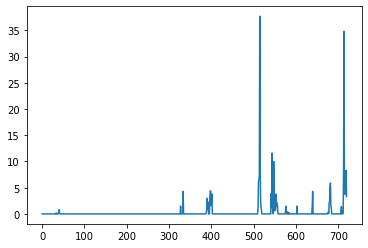

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

In [8]:
# Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow'))*50 #need array for EnKf function. should get this when initialize.  
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    soil_storage_avail = cfe_open.get_value('soil_storage_avail_m')
    surface_runoff_depth_m= cfe_open.get_value('DIRECT_RUNOFF') # surface_runoff_depth_m defined as in CFE
    print(" ###################cfe_open##################################")
    print(" cfe_open DIRECT_RUNOFF",surface_runoff_depth_m)
    print("soil_storage_avail",soil_storage_avail)

    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    # enkf.set_value('soil_storage_avail_m', soil_storage_avail_m) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_storage_avail_m) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff_depth_m) #setting runoff storage in enkf
    # print("surface_runoff_depth_m",surface_runoff_depth_m)
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf.update()
    #For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    # state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    # ENKF
    print("#################ENKF#####################")
    print("state_transition_soil_res",state_transition_soil_res)
    state_transition_runoff       = enkf.get_value('surface_runoff_ratio')
    #
    new_runoff=surface_runoff_depth_m*state_transition_runoff
    #
   
    # print(" ###################ENKF##################################")
    # print(" new DIRECT_RUNOFF",state_transition_runoff)
    # print("soil_storage_avail",state_transition_soil_res)
#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('state_var_change_runoff', state_transition_runoff) 
    
    cfe_analysis.update() #get new streamflow value based on state var change
    
    

    
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    print("outflow_analysis",outflow_analysis)
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_runoff = cfe_analysis.get_value('surface_runoff_depth_m')
    cfe_peturbed.set_value('surface_runoff_depth_m', cfe_updated_everything_runoff)
    # print("CFE Analysis",cfe_analysis.get_value('surface_runoff_depth_m'))
    # print("CFE",cfe_analysis.get_value('surface_runoff_depth_m'))
          
#    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
#    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff) #set state vars based on EnKF factor
#    cfe_updated_everything_soil = cfe_analysis.get_value('state_var_change_soil')
#    cfe_peturbed.set_value('state_var_change_soil', cfe_updated_everything_soil) #set state vars based on EnKF factor
   
    
# # Finalize models
# cfe_open.finalize(print_mass_balance=True)
# cfe_peturbed.finalize(print_mass_balance=True)
# #cfe_analysis.finalize(print_mass_balance=True)
# # want to see runoff q adjusted. vol adjusted in GIUH 
# usgs.finalize()
# enkf.finalize()

 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0
soil_storage_avail 0.0
 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res 0.0
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0
soil_storage_avail 0.0
 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res 0.0
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0
soil_storage_avail 0.0
 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res 0.0
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0
soil_storage_avail 0.0
 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res 0.0
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0

/home/jovyan/data/project/Draft/NextGen---The-Simulators-/Toy_Model/./Assimilation/EnKF.py:63: RuntimeWarning: divide by zero encountered in floor_divide
  e.factor=e.res//e.x
/home/jovyan/data/project/Draft/NextGen---The-Simulators-/Toy_Model/./Assimilation/Bmi_da_ENKF_forSBMI.py:196: RuntimeWarning: divide by zero encountered in true_divide
  self.surface_runoff_ratio = ((self.surface_runoff + leftover_depth_change_m)/self.surface_runoff)


 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res -0.1517605903085506
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0
soil_storage_avail -0.1517605903085506
 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res -0.1517605903085506
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0
soil_storage_avail -0.1517605903085506
 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res -0.1517605903085506
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0
soil_storage_avail -0.1517605903085506
 the runoff ratio 1
#################ENKF#####################
state_transition_soil_res -0.1517605903085506
outflow_analysis 0.0
 ###################cfe_open##################################
 cfe_open DIRECT_RUNOFF 0.0

In [ ]:
istart_plot=650
iend_plot=710
x = list(range(istart_plot, iend_plot))

fig = plt.figure(figsize = (7,5), dpi=300)

plt.title('Sub-Region Model DA Example')
#plt.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:blue', label = 'CFE Peturbed')
plt.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
plt.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'black', linestyle='dashed', label = 'CFE Analysis')
plt.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
plt.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
plt.ylabel('Streamflow (CFS)')
plt.xlabel('Time')
plt.legend()


In [ ]:
# cfe_open = bmi_cfe()
# cfe_perturbed = bmi_cfe()
# cfe_analysis = bmi_cfe()
# enkf = bmi_enkf()
# usgs = bmi_usgs()

# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

# For time in daterange():
#     forcing = forcings[time]
#     cfe_open.set_value(forcing)
#     cfe_perturbed.set_value(forcing)
#     cfe_analysis.set_value(forcing)
#     usgs.update()
#     obs = usgs.get_value()

#     cfe_open.update()
#     cfe_perturbed.update()
#     mean, variance  = cfe_perturbed.get_value()

#     enkf.set_value(obs, mean, variance )

#     state_transition = enkf.get_value()

#     cfe_analysis.set_value(state_transition)
#     cfe_analysis.update()

#     cfe_perturbed.set_value(state_transition)
#     

#     cfe_updated_everything = cfe_analysis.get_value(everything)
#     cfe_perturbed.set_value(cfe_updated_everything)



# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

